# kmer-based models for comparison

Maps input sequences into kmer space, then trains standard learning models.

I've been running these locally and with the exception of the SGDRegressor, they are very
slow to train... I have actually never trained the SVM...

Increasing k tends to help, but the memory requirements quickly get quite large.
My machine runs out of memory with k=5.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from mrpa_data import MrpaData
data = MrpaData()

In [6]:
def kmerize(seq, k):
    """
    Returns np.array of kmer counts corresponding to given seq
    """
    bases = {'A': '00', 'C': '01', 'G': '10', 'T': '11'}
    binary_seq = ''.join([bases[char] for char in seq])
    counts = np.zeros((4**k,))
    for i in range(0, len(seq) - k + 1):
        counts[int(''.join(binary_seq[i*2:(i+k)*2]), 2)] += 1
    return counts

In [7]:
from sklearn.preprocessing import MinMaxScaler
X = np.array([kmerize(data.seqs[key], 6) for key in data.valid_keys])

scale = MinMaxScaler((-1, 1))
y = scale.fit_transform(data.y_multitask())

In [12]:
import math
w = np.zeros(y.shape)
for i, experiment in enumerate(data._experiment_keys()):
    for j, key in enumerate(data.valid_keys):
        one, two = data.split_data[experiment][key]
        dot_prod = one + two
        norm = math.sqrt(one**2 + two**2)
        cos = dot_prod/(math.sqrt(2) * norm)
        sin = math.sqrt(1-cos**2)
        w[j, i] = sin * norm

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_valid, w_train, w_valid, y_train, y_valid = train_test_split(
    X, w, y, test_size=0.2, random_state=42
)

In [21]:
from sklearn.linear_model import SGDRegressor
sgd_models = []
for task in range(y.shape[1]):
    sgd_models += [SGDRegressor().fit(X_train, y_train[:, task], sample_weight = w_train[:, task])]

In [24]:
def print_errors(models):
    for task, model in enumerate(models):
        mse =  sum([(i-j) **2 / k for i, j, k in zip(model.predict(X_valid), y_valid[:, task], w[:, task])]) / sum(w[:, task])
        var = np.var(y_valid[:, task])
        print "MSE is {} and var is {}".format(mse, var)
        
def plot_predictions(models):
    for task, model in enumerate(models):
        plt.scatter(model.predict(X_valid), y_valid[:, task], s=.05)
        plt.show()

MSE is 0.0911108421012 and var is 0.0201927113906
MSE is 0.0551258575276 and var is 0.0316976839473
MSE is 0.0901294925414 and var is 0.050528089613
MSE is 0.0267924978442 and var is 0.0578688763482


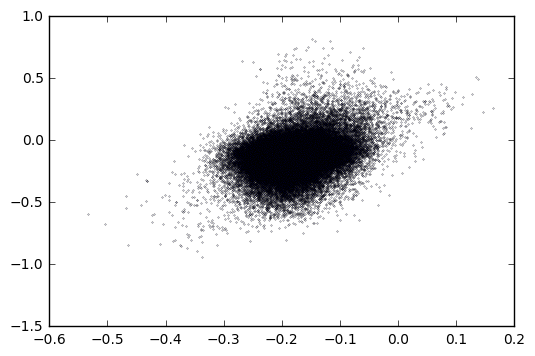

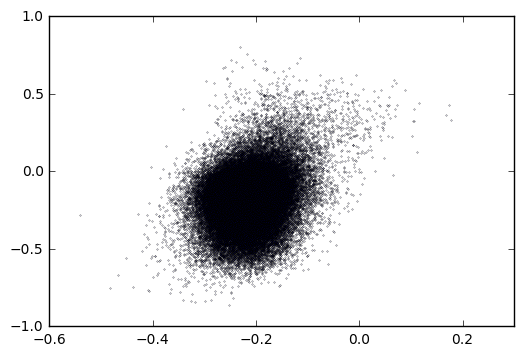

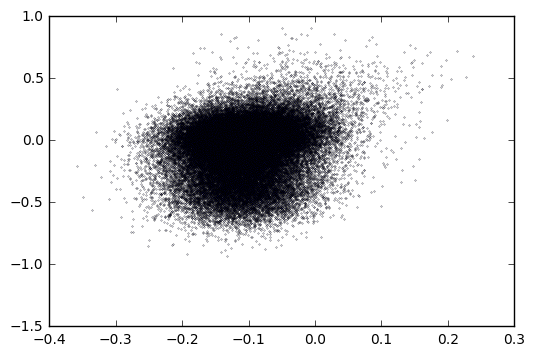

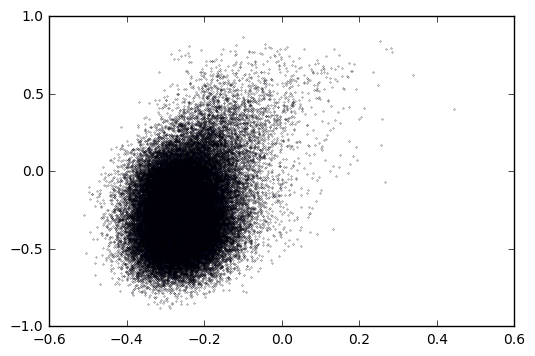

In [25]:
print_errors(sgd_models)
plot_predictions(sgd_models)